# Import Dependencies

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam, Nadam, AdamW, Lion
import tensorflow_hub as hub
from tensorflow.keras.preprocessing import image
import os, random

# Data Collection and Load

In [ ]:
%pip install gdown
!gdown --fuzzy "https://drive.google.com/file/d/1PdwPKo91TizcS6Lv_aB9SPhHxpP04bOS/view?usp=sharing"
!unzip 'Penyakit Retina Mata 3.zip'

In [ ]:
augmentation_layers = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.4),
    tf.keras.layers.RandomZoom(0.2)
])

In [ ]:
data_directory = './Penyakit Retina Mata 3/'
training_set_1 = tf.keras.preprocessing.image_dataset_from_directory(
    data_directory,
    color_mode='rgb',
    batch_size=128,
    image_size=((224, 224)),
    shuffle=True,
    label_mode='categorical',
    seed=123,
    validation_split=0.3,
    subset='training'
)
validation_set_1 = tf.keras.preprocessing.image_dataset_from_directory(
    data_directory,
    color_mode='rgb',
    batch_size=128,
    image_size=((224, 224)),
    shuffle=True,
    label_mode='categorical',
    seed=123,
    validation_split=0.3,
    subset='validation'
)

Found 4180 files belonging to 4 classes.
Using 2926 files for training.
Found 4180 files belonging to 4 classes.
Using 1254 files for validation.
Found 4180 files belonging to 4 classes.
Using 2926 files for training.
Found 4180 files belonging to 4 classes.
Using 1254 files for validation.


# Model

In [ ]:
get_mobilenet_v3_pretrained_model = "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5"
mobilenet_v3_pretrained_model = hub.KerasLayer(get_mobilenet_v3_pretrained_model, input_shape=(224, 224, 3), trainable=True)

In [ ]:
inputs_1 = tf.keras.Input(shape=(224, 224, 3))
x_1 = augmentation_layers(inputs_1)
x_1 = mobilenet_v3_pretrained_model(x_1)
x_1 = tf.keras.layers.BatchNormalization()(x_1)
x_1 = tf.keras.layers.Dropout(0.5)(x_1)
prediction_layer_1 = tf.keras.layers.Dense(4, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.05))
outputs_1 = prediction_layer_1(x_1)
model_1 = tf.keras.Model(inputs_1, outputs_1)

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1280)              4226432   
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 4)                 5124      
                                                             

In [ ]:
model_1.compile(optimizer=Lion(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
history_1 = model_1.fit(training_set_1, validation_data=validation_set_1, epochs=50)

Epoch 1/50
23/23 [==============================] - 74s 1s/step - loss: 2.8641 - accuracy: 0.3090 - val_loss: 2.3788 - val_accuracy: 0.1826
Epoch 2/50
23/23 [==============================] - 29s 1s/step - loss: 2.2172 - accuracy: 0.4621 - val_loss: 2.0597 - val_accuracy: 0.3214
Epoch 3/50
23/23 [==============================] - 28s 1s/step - loss: 1.8480 - accuracy: 0.5875 - val_loss: 1.7661 - val_accuracy: 0.4928
Epoch 4/50
23/23 [==============================] - 28s 996ms/step - loss: 1.6591 - accuracy: 0.6675 - val_loss: 1.5678 - val_accuracy: 0.6037
Epoch 5/50
23/23 [==============================] - 31s 1s/step - loss: 1.5051 - accuracy: 0.7051 - val_loss: 1.4435 - val_accuracy: 0.6730
Epoch 6/50
23/23 [==============================] - 28s 1s/step - loss: 1.4297 - accuracy: 0.7502 - val_loss: 1.3703 - val_accuracy: 0.6994
Epoch 7/50
23/23 [==============================] - 29s 1s/step - loss: 1.2905 - accuracy: 0.7915 - val_loss: 1.3331 - val_accuracy: 0.7321
Epoch 8/50
23/23 

# Evaluation

In [ ]:
def acc_visual(history):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='lower right')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

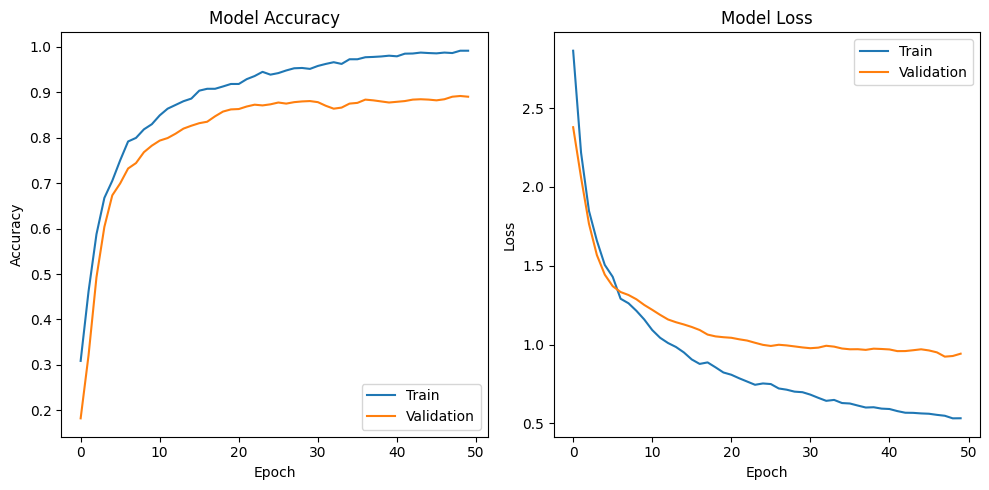

In [ ]:
acc_visual(history_1)

# Save and Load the Model

In [ ]:
model_1.save('model_1.keras')

# Model Testing

In [ ]:
test_model = tf.keras.models.load_model('model_1.keras', custom_objects={'KerasLayer':hub.KerasLayer})

In [ ]:
label = {
    "0":"Cataract",
    "1":"Diabetic Retinopathy",
    "2":"Glaucoma",
    "3":"Normal"
    }

def predict(image_directory, model):
  image = tf.keras.utils.load_img(image_directory, target_size=(224,224))
  input_arr = tf.keras.utils.img_to_array(image)
  input_arr = np.array([input_arr])
  predictions = np.argmax(model.predict(input_arr))
  return predictions

In [ ]:
!gdown --fuzzy "https://drive.google.com/file/d/1yw3jjTQfdornZRlI5SJqzbem3UcvIsY4/view?usp=sharing"
!unzip "upload test-20240502T062928Z-001.zip"

Downloading...
From: https://drive.google.com/uc?id=1yw3jjTQfdornZRlI5SJqzbem3UcvIsY4
To: /content/upload test-20240502T062928Z-001.zip
100% 59.2k/59.2k [00:00<00:00, 100MB/s]
Archive:  upload test-20240502T062928Z-001.zip
  inflating: upload test/diabetic retinophaty.jpg  
  inflating: upload test/glaucoma.jpg  
  inflating: upload test/normal.jpg  
  inflating: upload test/cataracs.jpg  


In [ ]:
for i in os.listdir('/content/upload test'):
    print(f"Class: {str(i)}, prediction: {label[str(predict(os.path.join('./upload test', i), test_model))]}")

1/1 [==============================] - 0s 39ms/step
Class: cataracs.jpg, prediction: Cataract
1/1 [==============================] - 0s 46ms/step
Class: diabetic retinophaty.jpg, prediction: Diabetic Retinopathy
1/1 [==============================] - 0s 51ms/step
Class: normal.jpg, prediction: Normal
1/1 [==============================] - 0s 50ms/step
Class: glaucoma.jpg, prediction: Glaucoma


# Evaluation and Confusion Matrix

In [ ]:
# Imports for evaluation
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# Define new metrics including precision and recall
from tensorflow.keras import metrics

METRICS = [
    metrics.CategoricalCrossentropy(name='categorical cross entropy'),  # change to CategoricalCrossentropy for multi-class
    metrics.MeanSquaredError(name='mean squared error'),
    metrics.TruePositives(name='true positive'),
    metrics.FalsePositives(name='false positive'),
    metrics.TrueNegatives(name='true negative'),
    metrics.FalseNegatives(name='false negative'),
    metrics.CategoricalAccuracy(name='accuracy'),  # change to CategoricalAccuracy for multi-class
    metrics.Precision(name='precision'),
    metrics.Recall(name='recall'),
    metrics.AUC(name='auc'),
    metrics.AUC(name='precision-recall curve', curve='PR') # precision-recall curve
]

# Recompile the model with the new metrics
test_model.compile(optimizer=model_1.optimizer,  # use the same optimizer
                loss=model_1.loss,  # use the same loss
                metrics=METRICS)

# Evaluate the model on the validation data
val_data = list(validation_set_1.take(len(validation_set_1)))
val_images, val_labels = zip(*[(x.numpy(), y.numpy()) for x, y in val_data])
val_images = np.concatenate(val_images)
val_labels = np.concatenate(val_labels)

test_predictions_baseline = test_model.predict(val_images, batch_size=128)

# Evaluate the model with new metrics
baseline_results = test_model.evaluate(val_images, val_labels, batch_size=128, verbose=0)

# Output results in percent
for name, value in zip(test_model.metrics_names, baseline_results):
    if name in ["true positive", "true negative", "false positive", "false negative"]:
      print(f"{name}: {value}")
    else:
      print(f"{name}: {value * 100:.2f}%")
print()

# Calculate precision and recall using sklearn
val_labels_argmax = np.argmax(val_labels, axis=1)
test_predictions_argmax = np.argmax(test_predictions_baseline, axis=1)

precision = precision_score(val_labels_argmax, test_predictions_argmax, average='weighted')
recall = recall_score(val_labels_argmax, test_predictions_argmax, average='weighted')

print(f"Precision (sklearn): {precision * 100:.2f}%")
print(f"Recall (sklearn): {recall * 100:.2f}%")


10/10 [==============================] - 2s 130ms/step
loss: 89.66%
categorical cross entropy: 38.62%
mean squared error: 4.15%
true positive: 1130.0
false positive: 123.0
true negative: 3639.0
false negative: 124.0
accuracy: 90.11%
precision: 90.18%
recall: 90.11%
auc: 97.56%
precision-recall curve: 94.36%

Precision (sklearn): 90.84%
Recall (sklearn): 90.11%


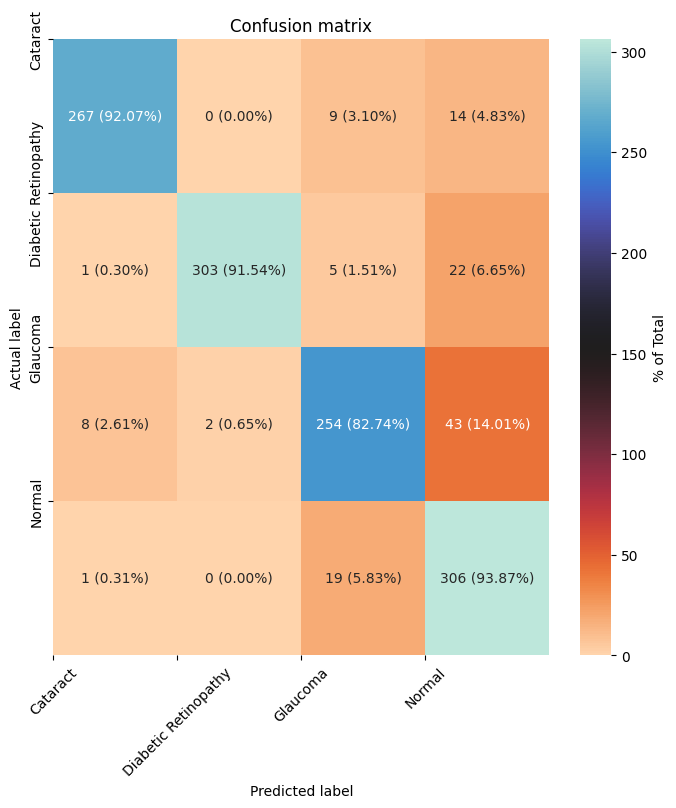

In [ ]:
# Fungsi untuk visualisasi confusion matrix
def plot_cm(label_matrix, predictions, class_names):
    preds = np.argmax(predictions, axis=1)
    labels_ = np.argmax(label_matrix, axis=1)
    cm = confusion_matrix(labels_, preds, labels=np.arange(len(class_names)))
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            annot[i, j] = f'{cm[i, j]} ({cm_normalized[i, j]:.2f}%)'
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=annot, fmt="", cmap="icefire_r", cbar_kws={'label': '% of Total'})
    indices = np.arange(len(class_names))
    plt.xticks(indices, class_names, rotation=45)
    plt.yticks(indices, class_names)
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

class_names = ["Cataract", "Diabetic Retinopathy", "Glaucoma", "Normal"]
plot_cm(val_labels, test_predictions_baseline, class_names)

10/10 [==============================] - 2s 128ms/step
loss: 89.66%
cross_entropy: 38.62%
Brier_score: 4.15%
tp: 113000.00%
fp: 12300.00%
tn: 363900.00%
fn: 12400.00%
accuracy: 90.11%
precision: 90.18%
recall: 90.11%
auc: 97.56%
prc: 94.36%

Precision (sklearn): 90.84%
Recall (sklearn): 90.11%


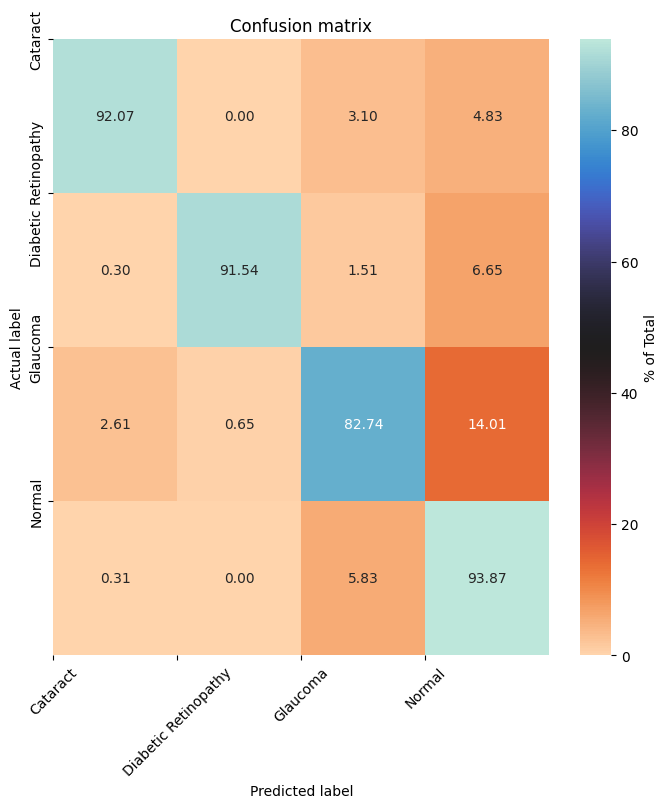

In [ ]:
# Fungsi untuk visualisasi confusion matrix
def plot_cm(label_matrix, predictions, class_names):
    preds = np.argmax(predictions, axis=1)
    labels_ = np.argmax(label_matrix, axis=1)
    cm = confusion_matrix(labels_, preds, labels=np.arange(len(class_names)))
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    plt.figure(figsize=(8,8))
    # Prepare annotations in the format "numbers (percentage)"
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            annot[i, j] = f'{cm[i, j]} ({cm_normalized[i, j]:.2f}%)'
    # Plot the heatmap
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=annot, fmt="", cmap="icefire_r", cbar_kws={'label': '% of Total'})
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="icefire_r", cbar_kws={'label': '% of Total'})
    # sns.heatmap(cm, annot=True, fmt="d", cmap="icefire_r")
    indices = np.arange(len(class_names))
    plt.xticks(indices, class_names, rotation=45)
    plt.yticks(indices, class_names)
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

class_names = ["Cataract", "Diabetic Retinopathy", "Glaucoma", "Normal"]
plot_cm(val_labels, test_predictions_baseline, class_names)

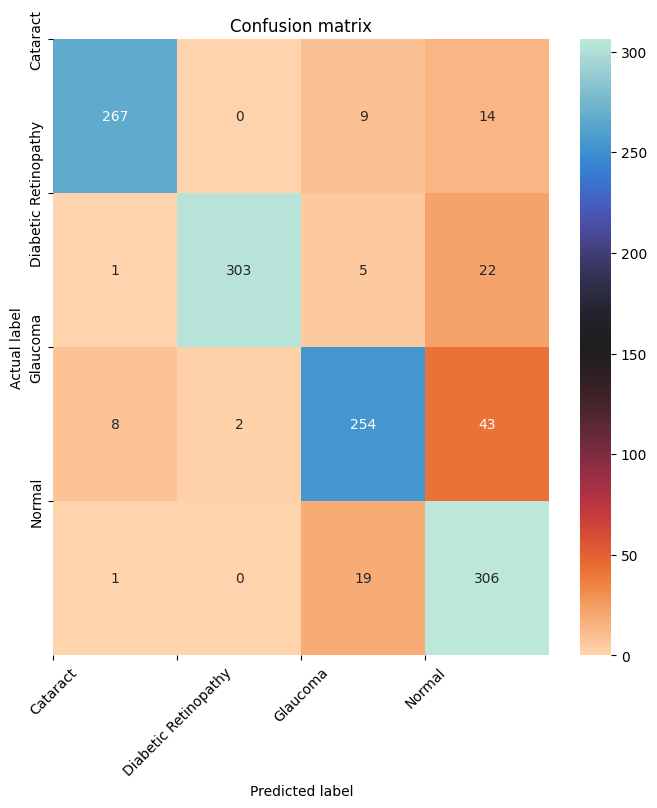

In [ ]:
# Fungsi untuk visualisasi confusion matrix
def plot_cm(label_matrix, predictions, class_names):
    preds = np.argmax(predictions, axis=1)
    labels_ = np.argmax(label_matrix, axis=1)
    cm = confusion_matrix(labels_, preds, labels=np.arange(len(class_names)))
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    plt.figure(figsize=(8,8))
    # sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="icefire_r", cbar_kws={'label': '% of Total'})
    sns.heatmap(cm, annot=True, fmt="d", cmap="icefire_r")
    indices = np.arange(len(class_names))
    plt.xticks(indices, class_names, rotation=45)
    plt.yticks(indices, class_names)
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

class_names = ["Cataract", "Diabetic Retinopathy", "Glaucoma", "Normal"]
plot_cm(val_labels, test_predictions_baseline, class_names)